<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/covid19_(14_10_22).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

# Uploading The Dataset

In [2]:
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"latifuljoy","key":"c9493e600d8dfc76ec7a58ea29031a33"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d latifuljoy/covid-chest-xray-image-dataset

 99% 481M/484M [00:18<00:00, 23.4MB/s]
100% 484M/484M [00:18<00:00, 26.9MB/s]


In [5]:
!unzip \*.zip

Archive:  covid-chest-xray-image-dataset.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png 

In [6]:
for dirpath,dirnames,filenames in os.walk("/content/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 536 images in '/content/COVID_IEEE/normal'.
there are 0 directories and 536 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 536 images in '/content/COVID_IEEE/covid'.


In [7]:
import pathlib
import tensorflow as tf
data_dir = pathlib.Path("/content/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

# Data Preprocessing

In [8]:
img_height =224
img_width =224

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'training',
    seed =123,
    image_size = (img_height, img_width),
    batch_size =64
)

Found 1493 files belonging to 3 classes.
Using 1195 files for training.


In [10]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'validation',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 64
)

Found 1493 files belonging to 3 classes.
Using 298 files for validation.


# Normalization

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [12]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, label_batch= next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in (0,1)
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_ds= validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Developed CNN Model

In [26]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0005)

In [27]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))


#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

Dropout(0.40)


# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))

model.add(Dense(units= 256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
Dropout(0.40)

model.add(Dense(units=3, activation="softmax"))

In [28]:
model.compile(optimizer = opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [29]:
history1 = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
19/19 [==============================] - 5s 247ms/step - loss: 1.4510 - accuracy: 0.4126 - val_loss: 0.9835 - val_accuracy: 0.3993
Epoch 2/20
19/19 [==============================] - 5s 239ms/step - loss: 0.7452 - accuracy: 0.6812 - val_loss: 0.5094 - val_accuracy: 0.8121
Epoch 3/20
19/19 [==============================] - 5s 241ms/step - loss: 0.4245 - accuracy: 0.8310 - val_loss: 0.4529 - val_accuracy: 0.8523
Epoch 4/20
19/19 [==============================] - 5s 242ms/step - loss: 0.2888 - accuracy: 0.8987 - val_loss: 0.3027 - val_accuracy: 0.8960
Epoch 5/20
19/19 [==============================] - 5s 243ms/step - loss: 0.2777 - accuracy: 0.8996 - val_loss: 0.5420 - val_accuracy: 0.7617
Epoch 6/20
19/19 [==============================] - 5s 244ms/step - loss: 0.3345 - accuracy: 0.8703 - val_loss: 0.3272 - val_accuracy: 0.8725
Epoch 7/20
19/19 [==============================] - 5s 246ms/step - loss: 0.2076 - accuracy: 0.9314 - val_loss: 0.2703 - val_accuracy: 0.8960
Epoch 

Text(0.5, 1.0, 'Accuracy Curves')

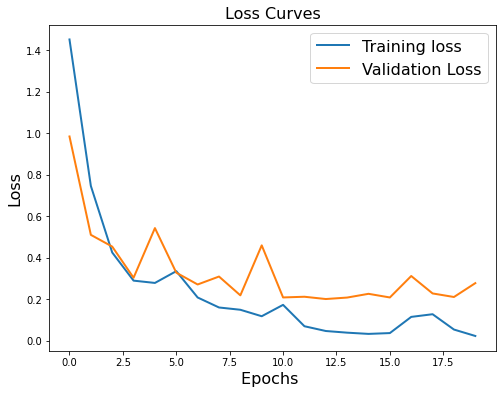

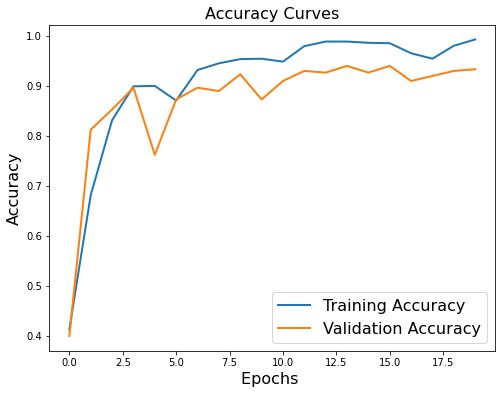

In [30]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],linewidth=2.0)
plt.plot(history1.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],linewidth=2.0)
plt.plot(history1.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
model.save("/content/drive/MyDrive/model.hdf5")

# Transfer Learning Model Inception V3

In [31]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [32]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = InceptionV3(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model1 = Model(inputs = base_model.inputs, outputs = predictions)

87910968/87910968 [==============================] - 0s 0us/step


In [33]:
model1.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [34]:
history2 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
19/19 [==============================] - 26s 801ms/step - loss: 0.5648 - accuracy: 0.7573 - val_loss: 1.0633 - val_accuracy: 0.5201
Epoch 2/20
19/19 [==============================] - 9s 460ms/step - loss: 0.1104 - accuracy: 0.9724 - val_loss: 1.4775 - val_accuracy: 0.5000
Epoch 3/20
19/19 [==============================] - 9s 462ms/step - loss: 0.0253 - accuracy: 0.9950 - val_loss: 1.5907 - val_accuracy: 0.5570
Epoch 4/20
19/19 [==============================] - 9s 456ms/step - loss: 0.0097 - accuracy: 0.9992 - val_loss: 1.4250 - val_accuracy: 0.6644
Epoch 5/20
19/19 [==============================] - 9s 452ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 1.2843 - val_accuracy: 0.7416
Epoch 6/20
19/19 [==============================] - 8s 448ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.9714 - val_accuracy: 0.7886
Epoch 7/20
19/19 [==============================] - 8s 446ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7130 - val_accuracy: 0.8356
Epoch

In [45]:
model1.save("/content/drive/MyDrive/model1.hdf5")

# DenseNet121

In [50]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [51]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = DenseNet121(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model2 = Model(inputs = base_model.inputs, outputs = predictions)

In [52]:
model2.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [53]:
history3 = model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
19/19 [==============================] - 26s 795ms/step - loss: 0.4340 - accuracy: 0.8293 - val_loss: 0.5465 - val_accuracy: 0.7919
Epoch 2/20
19/19 [==============================] - 13s 701ms/step - loss: 0.0745 - accuracy: 0.9757 - val_loss: 0.4331 - val_accuracy: 0.8389
Epoch 3/20
19/19 [==============================] - 13s 706ms/step - loss: 0.0223 - accuracy: 0.9958 - val_loss: 0.3509 - val_accuracy: 0.8456
Epoch 4/20
19/19 [==============================] - 14s 726ms/step - loss: 0.0099 - accuracy: 0.9992 - val_loss: 0.3315 - val_accuracy: 0.8826
Epoch 5/20
19/19 [==============================] - 14s 738ms/step - loss: 0.0055 - accuracy: 0.9992 - val_loss: 0.2846 - val_accuracy: 0.9027
Epoch 6/20
19/19 [==============================] - 14s 723ms/step - loss: 0.0039 - accuracy: 0.9983 - val_loss: 0.2509 - val_accuracy: 0.9128
Epoch 7/20
19/19 [==============================] - 13s 711ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2263 - val_accuracy: 0.9362

In [54]:
model2.save("/content/drive/MyDrive/model2.hdf5")

# MobileNet

In [39]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [40]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = MobileNet(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model3 = Model(inputs = base_model.inputs, outputs = predictions)

17225924/17225924 [==============================] - 1s 0us/step


In [41]:
model3.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [42]:
history4 = model3.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
19/19 [==============================] - 10s 353ms/step - loss: 0.5899 - accuracy: 0.7523 - val_loss: 3.2904 - val_accuracy: 0.5537
Epoch 2/20
19/19 [==============================] - 5s 257ms/step - loss: 0.1316 - accuracy: 0.9565 - val_loss: 3.2491 - val_accuracy: 0.5369
Epoch 3/20
19/19 [==============================] - 5s 258ms/step - loss: 0.0461 - accuracy: 0.9891 - val_loss: 2.9295 - val_accuracy: 0.5436
Epoch 4/20
19/19 [==============================] - 5s 261ms/step - loss: 0.0189 - accuracy: 0.9983 - val_loss: 2.8505 - val_accuracy: 0.5134
Epoch 5/20
19/19 [==============================] - 5s 266ms/step - loss: 0.0111 - accuracy: 0.9992 - val_loss: 2.9525 - val_accuracy: 0.5000
Epoch 6/20
19/19 [==============================] - 5s 267ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 2.6439 - val_accuracy: 0.5168
Epoch 7/20
19/19 [==============================] - 5s 267ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 2.5741 - val_accuracy: 0.5000
Epoch

In [47]:
model3.save("/content/drive/MyDrive/model3.hdf5")

# Ensemble Learning Model 1

In [55]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [59]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model("/content/drive/MyDrive/model.hdf5")
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/MyDrive/model1.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

model_3 = load_model('/content/drive/MyDrive/model2.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [60]:
ensemble_model.compile(optimizer = opt, 
                       loss= tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics = ['accuracy'])

In [61]:
history = ensemble_model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs =15
)

Epoch 1/15
 4/19 [=====>........................] - ETA: 18s - loss: 0.0043 - accuracy: 1.0000

ResourceExhaustedError: ignored

# Ensemble Learning Model 2

In [62]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [63]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_4 = load_model("/content/drive/MyDrive/model3.hdf5")
model_4 = Model(inputs=model_4.inputs,
                outputs=model_4.outputs,
                name='name_of_model_4')
model_2 = load_model('/content/drive/MyDrive/model1.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

model_3 = load_model('/content/drive/MyDrive/model2.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [64]:
ensemble_model.compile(optimizer = opt, 
                       loss= tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics = ['accuracy'])

In [66]:
history = ensemble_model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs =20
)

Epoch 1/20


ResourceExhaustedError: ignored